<a href="https://colab.research.google.com/github/yanapatt/Smart-Skin-Cancer-Assistant-CNN-Model/blob/main/Benchmark_(MobileNetV3Large)_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Benchmark CNN Model**
---
**คำอธิบาย**  
ไฟล์ Jupyter notebook ใช้สำหรับการ Train CNN Model

---
**Group Oscar Do Everything**  
**หัวข้อ Smart Skin Cancer Assistant CNN Model**  
**สมาชิก**

* 66102010137	นายณัฐนนท์ หลิมเหล็ก
* 66102010145	นายพชรดนัย กุระกนก
* 66102010153	นายศิลายุชย์ โชติธรรมาภรณ์
* 66102010236	นายญาณภัทร ปานเกษม

**รายวิชา**
**CP461 Introduction to Computer Vision**

**Main Reference : An Interpretable Deep Learning Approach for Skin Cancer Categorization**  

**Paper Link:** https://arxiv.org/abs/2312.10696  
**GitHub:** https://github.com/Faysal-MD/An-Interpretable-Deep-Learning-Approach-for-Skin-Cancer-Categorization-IEEE2023?utm_source=chatgpt.com

## **Section 0: Import important library**

In [1]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.0
    Uninstalling wrapt-2.0.0:
      Successfully uninstalled wrapt-2.0.0


In [1]:
import os
import itertools
import time
from psutil import virtual_memory

import pandas as pd
import numpy as np
import random as rd

import tensorflow as tf
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.saliency import Saliency
import tf_keras_vis
import keras
os.environ["KERAS_BACKEND"] = "tensorflow"
import sklearn
import joblib

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import cv2
import albumentations as A

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Setting a seed system environment**

In [2]:
def set_seed(seed):
    """
        ใช้สำหรับการตั้งค่า Seed Environment เพื่อให้ผลลัพธ์สามารถ Reproduce ได้
        Arg:
            seed คือ ค่า Integer สำหรับกำหนด Seed
    """
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()
    keras.utils.set_random_seed(seed)

    np.random.seed(seed)
    rd.seed(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"

    print(f"The seed number has been set at {seed}")

In [3]:
SEED = 42
set_seed(SEED)

The seed number has been set at 42


In [4]:
gpu_info = !nvidia-smi
gpu_info = "\n".join(gpu_info)
if gpu_info.find("failed") >= 0:
  print("Not connected to a GPU")
else:
  print(gpu_info)

ram_gb = virtual_memory().total / 1e9
print(f"Your runtime has {ram_gb:.1f} gigabytes of available RAM")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

Sun Oct 26 15:06:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   70C    P8             20W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## **Section 1: Preparing the directory for dataset and model**

### **In G-Drive Directory**

In [5]:
DRIVE_DIR = "/content/drive/MyDrive/CP461/mainProject" # Drive Directory
ASSETS_PATH = f"{DRIVE_DIR}/assets" # Assets Path
DATASET_ZIP_PATH = f"{DRIVE_DIR}/datasets/ham10000Dataset.zip"
INDEX_SETTING = f"{DRIVE_DIR}/datasets/indexSetting"

In [6]:
# Setting font
fm.fontManager.addfont(f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_prop = fm.FontProperties(fname=f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_name = font_prop.get_name()
plt.rcParams["font.family"] = font_name

In [7]:
MODEL_PATH = f"{DRIVE_DIR}/models" # <= สำหรับเก็บ Log Model ต่าง ๆ
MODEL_NAME = "MobileNetV3Large" # <= Model อะไร
OPTIMIZER_NAME = "Adam" # <= Optimizer อะไร
TYPE = "FeatureExtraction" # <= Fine-Tuned หรือ Feature Extraction
ROUND_NUM = 2 # <= รันครั้งที่เท่าไหร่
MODEL_FULL_PATH = f"{MODEL_PATH}/{MODEL_NAME}_{TYPE}_{OPTIMIZER_NAME}_{ROUND_NUM}"
ASSETS_FOR_MODEL_PATH = f"{MODEL_FULL_PATH}/assets" # <= สำหรับเก็บรูปภาพต่าง ๆ จากโมเดล

os.makedirs(MODEL_FULL_PATH, exist_ok=True)
os.makedirs(ASSETS_FOR_MODEL_PATH, exist_ok=True)

In [8]:
MODEL_KERAS_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}.keras"
MODEL_H5_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}.h5"
MODEL_TFLITE_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}.tflite"
MODEL_CHECKPOINT_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_best.keras"
MODEL_TENSORBOARD_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_tensorboard.logs"
MODEL_HISTORY_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_history.csv"
MODEL_JSON_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_json.json"
MODEL_REPORT_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_report.csv"

### **In Runtime Directory**

In [11]:
!unzip /content/drive/MyDrive/CP461/mainProject/datasets/ham10000Dataset.zip -d /content/ham10000Dataset

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: /content/ham10000Dataset/nv/ISIC_0029911.jpg  
  inflating: /content/ham10000Dataset/nv/ISIC_0032193.jpg  
  inflating: /content/ham10000Dataset/nv/ISIC_0026960.jpg  
  inflating: /content/ham10000Dataset/nv/ISIC_0032054.jpg  
  inflating: /content/ham10000Dataset/nv/ISIC_0028066.jpg  
  inflating: /content/ham10000Dataset/nv/ISIC_0033119.jpg  
  inflating: /content/ham10000Dataset/nv/ISIC_0030336.jpg  
  inflating: /content/ham10000Dataset/nv/ISIC_0029614.jpg  
  inflating: /content/ham10000Dataset/nv/ISIC_0027945.jpg  
  inflating: /content/ham10000Dataset/nv/ISIC_0030232.jpg  
  inflating: /content/ham10000Dataset/nv/ISIC_0027600.jpg  
  inflating: /content/ham10000Dataset/nv/ISIC_0031094.jpg  
  inflating: /content/ham10000Dataset/nv/ISIC_0026757.jpg  
  inflating: /content/ham10000Dataset/nv/ISIC_0034305.jpg  
  inflating: /content/ham10000Dataset/nv/ISIC_0031251.jpg  
  inflating: /content/ham10000Dataset/nv/IS

In [9]:
DATASET_DIR = "/content/ham10000Dataset"

## **Section 2: Preprocessing and augmentaion images**

### **Load dataset**

In [10]:
class MultiModelDatasetPipeline:
    def __init__(self,
                 transform=None,
                 rescale=None,
                 preprocess_input=None
                 ):

        self.transform = transform
        self.rescale = rescale
        self.preprocess_input = preprocess_input
        self.AUTOTUNE = tf.data.AUTOTUNE
        self.class_names = None

    def _transform_function(self, img_numpy):
        raw_img = {"image": img_numpy}
        transform_img = self.transform(**raw_img)
        return transform_img["image"].astype(np.float32)

    @tf.function
    def _apply_transform(self, img_tensor, img_size):
        transformed = tf.numpy_function(
            func=self._transform_function,
            inp=[img_tensor],
            Tout=tf.float32
        )
        transformed.set_shape([img_size[0], img_size[1], 3])
        return transformed

    def _load_and_resize(self, filepath, metadata, label, img_size):
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        return img, metadata, label

    def _finalize_data(self, img, metadata, label,
                         num_classes, img_size, is_training=False):

        if is_training and self.transform:
            img = self._apply_transform(img, img_size)

        if self.preprocess_input:
            img = self.preprocess_input(img)
        elif self.rescale:
            img = img * self.rescale

        label = tf.one_hot(label, num_classes)
        return ((img, metadata), label)

    def flow_from_dataframe(
            self,
            df,
            X_cols,
            X_meta,
            y_cols,
            num_classes,
            class_name_col=None,
            target_size=(224, 224),
            batch_size=32,
            is_training=False,
            seed=42
            ):

        num_files = len(df)

        if is_training and class_name_col and self.class_names is None:
            try:
                mapping_df = df[[y_cols, class_name_col]].drop_duplicates().sort_values(by=y_cols)
                self.class_names = mapping_df[class_name_col].tolist()

                if len(self.class_names) != num_classes:
                     print(f"Warning: Found {len(self.class_names)} unique names, but num_classes={num_classes}.")
            except Exception as e:
                print(f"Could not build class name list from '{class_name_col}': {e}. Defaulting to numeric names.")
                self.class_names = [str(i) for i in range(num_classes)]
        elif self.class_names is None:
            # ถ้าไม่ได้รัน Train ก่อน หรือไม่ระบุ class_name_col
             self.class_names = [str(i) for i in range(num_classes)]

        class_indices = dict(enumerate(self.class_names))

        print(f"Found {num_files} files belonging to {num_classes} classes.")
        print(f"Class indices: {class_indices}")

        dataset = tf.data.Dataset.from_tensor_slices(
            (df[X_cols].values, X_meta, df[y_cols].values)
        )

        dataset = dataset.map(
            lambda f, m, l: self._load_and_resize(f, m, l, target_size),
            num_parallel_calls=self.AUTOTUNE
        )
        dataset = dataset.cache()

        if is_training:
            dataset = dataset.shuffle(buffer_size=len(df), seed=seed, reshuffle_each_iteration=True)
            map_func = lambda img, m, l: self._finalize_data(img, m, l,
                                                             num_classes,
                                                             target_size,
                                                             is_training)
        else:
            map_func = lambda img, m, l: self._finalize_data(img, m, l,
                                                             num_classes,
                                                             target_size,
                                                             is_training)

        dataset = (
            dataset
            .map(map_func, num_parallel_calls=self.AUTOTUNE)
            .batch(batch_size)
            .prefetch(buffer_size=self.AUTOTUNE)
        )
        return dataset

In [11]:
df_train = pd.read_csv(f"{INDEX_SETTING}/metadata_train.csv")
df_val = pd.read_csv(f"{INDEX_SETTING}/metadata_val.csv")
df_test = pd.read_csv(f"{INDEX_SETTING}/metadata_test.csv")
metadata_preprocessing = joblib.load(f"{INDEX_SETTING}/metadata_preprocessing.joblib")

print("Check shape of dataframe")
print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

Check shape of dataframe
Train shape: (8020, 10)
Validation shape: (1005, 10)
Test shape: (990, 10)


In [12]:
X_meta_train = metadata_preprocessing.transform(df_train)
X_meta_val = metadata_preprocessing.transform(df_val)
X_meta_test = metadata_preprocessing.transform(df_test)
print("Transform complete.")

print("Check shape of metadata")
print(f"X Train metadata shape: {X_meta_train.shape}")
print(f"X Validation metadata shape: {X_meta_val.shape}")
print(f"X Test metadata shape: {X_meta_test.shape}")

Transform complete.
Check shape of metadata
X Train metadata shape: (8020, 18)
X Validation metadata shape: (1005, 18)
X Test metadata shape: (990, 18)


In [13]:
META_SHAPE = (X_meta_train.shape[1], )
print(f"Metadata shape: {META_SHAPE}")

Metadata shape: (18,)


In [14]:
def select_preprocess_input(model_name):
    if model_name == "Xception":
        preprocess_input = keras.applications.xception.preprocess_input
    elif model_name == "ResNet50":
        preprocess_input = keras.applications.resnet50.preprocess_input
    elif model_name == "MobileNetV3Large" or model_name == "MobileNetV3Small":
        preprocess_input = keras.applications.mobilenet_v3.preprocess_input
    elif model_name == "VGG16":
        preprocess_input = keras.applications.vgg16.preprocess_input
    elif model_name == "InceptionV3":
        preprocess_input = keras.applications.inception_v3.preprocess_input
    else:
        preprocess_input = None
    return preprocess_input

In [15]:
preprocess_input = select_preprocess_input(MODEL_NAME)
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
INPUT_SHAPE = IMAGE_SIZE + (3, )
BATCH_SIZE = 64
EPOCHS = 30

In [16]:
class_names = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]
idx_to_class = {idx: name for idx, name in enumerate(class_names)}
NUM_CLASSES = len(class_names)
print(f"Index to class: {idx_to_class}")
print(f"Number of classes: {NUM_CLASSES}")

Index to class: {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
Number of classes: 7


In [17]:
'''transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(
        translate_percent={"x": (-0.2, 0.2), "y": (-0.15, 0.15)},
        rotate=(-30, 30),
        shear=(-20, 20),
        scale=(0.9, 1.2),
        border_mode=cv2.BORDER_REPLICATE,
        p=0.2
    ),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=15, p=0.2),
], seed=SEED)'''

'transform = A.Compose([\n    A.HorizontalFlip(p=0.5),\n    A.Affine(\n        translate_percent={"x": (-0.2, 0.2), "y": (-0.15, 0.15)},\n        rotate=(-30, 30),\n        shear=(-20, 20),\n        scale=(0.9, 1.2),\n        border_mode=cv2.BORDER_REPLICATE,\n        p=0.2\n    ),\n    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),\n    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=15, p=0.2),\n], seed=SEED)'

In [17]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
], seed=SEED)

pipeline = MultiModelDatasetPipeline(
    transform=transform,
    rescale=None,
    preprocess_input=preprocess_input
)

In [18]:
ds_train = pipeline.flow_from_dataframe(
    df=df_train,
    X_cols="filepaths",
    X_meta=X_meta_train,
    y_cols="cell_type_idx",
    num_classes=NUM_CLASSES,
    class_name_col="dx",
    is_training=True,
    batch_size=BATCH_SIZE,
    seed=SEED
)

ds_val = pipeline.flow_from_dataframe(
    df=df_val,
    X_cols="filepaths",
    X_meta=X_meta_val,
    y_cols="cell_type_idx",
    num_classes=NUM_CLASSES,
    class_name_col="dx",
    is_training=False,
    batch_size=BATCH_SIZE
)

ds_test = pipeline.flow_from_dataframe(
    df=df_test,
    X_cols="filepaths",
    X_meta=X_meta_test,
    y_cols="cell_type_idx",
    num_classes=NUM_CLASSES,
    class_name_col="dx",
    is_training=False,
    batch_size=BATCH_SIZE
)

Found 8020 files belonging to 7 classes.
Class indices: {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
Found 1005 files belonging to 7 classes.
Class indices: {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
Found 990 files belonging to 7 classes.
Class indices: {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}


### **Compute class weights**

In [19]:
y_train_labels = df_train["cell_type_idx"].values

class_weights = sklearn.utils.class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weights_dict}")

Class weights: {0: np.float64(4.32345013477089), 1: np.float64(2.7674258109040717), 2: np.float64(1.3004702448516297), 3: np.float64(13.169129720853858), 4: np.float64(1.2801276935355148), 5: np.float64(0.21343410687672984), 6: np.float64(10.415584415584416)}


## **Section 3: Preparing the model**

### **Define callback function**

In [20]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 3,
    mode = "max",
    min_lr = 1e-06,
    verbose = 1
) # Reduce learning rate callback

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = MODEL_CHECKPOINT_PATH,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True,
    save_weights_only = False,
    verbose = 1
) # Model checkpoint for save best model file

tensorboard = keras.callbacks.TensorBoard(
    log_dir = MODEL_TENSORBOARD_PATH,
    histogram_freq = 1,
    write_graph = True,
    write_images = True
) # Tensorboard file

callback_list = [reduce_lr, model_checkpoint, tensorboard]

### **Model parameters**

In [21]:
def build_model(input_shape, meta_shape, num_classes, trainable=False):
    # Define input
    image_input = keras.layers.Input(shape=input_shape, name="image_input")
    meta_input = keras.layers.Input(shape=meta_shape, name="metadata_input")

    # Branch 1 For image input
    base_model = keras.applications.MobileNetV3Large(
        input_tensor=image_input,
        include_top=False,
        weights="imagenet",
    )
    for layer in base_model.layers:
        layer.trainable = trainable

    image_features = keras.layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    image_features = keras.layers.Dense(256, activation="relu", name="img_fc")(image_features)

    # Branch 2 For metadata
    meta_features = keras.layers.Dense(8, activation="relu", name="meta_fc1")(meta_input)
    meta_features = keras.layers.Dense(4, activation="relu", name="meta_fc2")(meta_features)

    # Concatenate feature map
    combined_features = keras.layers.Concatenate(name="concatenate_feature")([image_features, meta_features])

    # Classification Head
    # เพื่อให้โมเดลเรียนรู้ความสัมพันธ์ระหว่าง 2 Branch และกัน Overfit
    head = keras.layers.Dropout(0.2, name="head_dropout")(combined_features)
    head = keras.layers.Dense(128, activation="relu", name="head_fc")(head)
    predictions = keras.layers.Dense(num_classes, activation="softmax", name="predictions")(head)

    model = keras.models.Model(inputs=[image_input, meta_input], outputs=predictions)
    return model

In [22]:
model = build_model(
    input_shape=INPUT_SHAPE,
    meta_shape=META_SHAPE,
    num_classes=NUM_CLASSES,
    trainable=False
)

In [23]:
model.compile(
    optimizer = keras.optimizers.Adam(
        learning_rate = 1e-03,
        beta_1 = 0.9,
        beta_2 = 0.999,
        epsilon = 1e-08
    ),
    loss = keras.losses.CategoricalCrossentropy(name="loss"),
    metrics = [
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Precision(name="precision")
        ]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ image_input[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,276,867 (12.50 MB)

 Trainable params: 280,515 (1.07 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

## **Section 4: Training the model**

In [24]:
training_start = time.time()

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=callback_list,
    verbose=1
)

training_end = time.time()
training_time = training_end - training_start
print(f"\n Training completed in {training_time:.4f} seconds")

Epoch 1/30
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6706 - loss: 1.0369 - precision: 0.7547 - recall: 0.5916
Epoch 1: val_accuracy improved from -inf to 0.72537, saving model to /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3Large_FeatureExtraction_Adam_2/MobileNetV3Large_best.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 71s 162ms/step - accuracy: 0.6711 - loss: 1.0347 - precision: 0.7553 - recall: 0.5922 - val_accuracy: 0.7254 - val_loss: 0.7414 - val_precision: 0.8146 - val_recall: 0.6557 - learning_rate: 0.0010
Epoch 2/30
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7390 - loss: 0.7365 - precision: 0.8288 - recall: 0.6701
Epoch 2: val_accuracy improved from 0.72537 to 0.75423, saving model to /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3Large_FeatureExtraction_Adam_2/MobileNetV3Large_best.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.7391 - loss: 0.7361 - precision: 0.8289 - recall: 0.6701 - val_accuracy: 0.7542 - val_los

### **Save the model config**

In [25]:
# Save model history
history_df = pd.DataFrame(history.history)
history_df.to_csv(MODEL_HISTORY_PATH, index=False)
print(f"History has been saved at {MODEL_HISTORY_PATH}")

History has been saved at /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3Large_FeatureExtraction_Adam_2/MobileNetV3Large_history.csv


In [26]:
# Save model file and tensorboard
model.save(MODEL_KERAS_PATH) # Keras format
print(f"Model keras format has been saved to: {MODEL_KERAS_PATH}")
model.save(MODEL_H5_PATH) # h5 format
print(f"Model h5 format has been saved to: {MODEL_H5_PATH}")
model = keras.models.load_model(MODEL_CHECKPOINT_PATH) # Load best weight model

Model keras format has been saved to: /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3Large_FeatureExtraction_Adam_2/MobileNetV3Large.keras
Model h5 format has been saved to: /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3Large_FeatureExtraction_Adam_2/MobileNetV3Large.h5


In [27]:
model = keras.models.load_model(MODEL_CHECKPOINT_PATH) # Load best weight model

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(MODEL_TFLITE_PATH, "wb") as f:
    f.write(tflite_model) # tflite format
    print(f"Model tflite format has been saved to: {MODEL_TFLITE_PATH}")

json_model = model.to_json() #Save as json format
with open(MODEL_JSON_PATH, "w") as json_file:
    json_file.write(json_model)
    print(f"Model json format has been saved to: {MODEL_JSON_PATH}")

Saved artifact at '/tmp/tmpc77lx1rn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='image_input'), TensorSpec(shape=(None, 18), dtype=tf.float32, name='metadata_input')]
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  138607032944400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138605934170320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138605934171472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138605934170512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138605934172048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138605934170704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138605934167248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138605934171856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138605934170128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13860593

## **Section 5: Evaluation the model**

In [29]:
results = model.evaluate(ds_test, return_dict=True)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6818 - loss: 1.0216 - precision: 0.7019 - recall: 0.6570


In [30]:
results

{'accuracy': 0.8111110925674438,
 'loss': 0.6300749778747559,
 'precision': 0.8305262923240662,
 'recall': 0.7969697117805481}

In [31]:
loss = results['loss']
accuracy = results['accuracy']
precision = results['precision']
recall = results['recall']

print(f"--Final Test Results--")
print(f"Loss      : {loss:.4f}")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")

--Final Test Results--
Loss      : 0.6301
Accuracy  : 0.8111
Precision : 0.8305
Recall    : 0.7970


In [32]:
y_pred_prob = model.predict(ds_test)

y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_onehot = keras.utils.to_categorical(y_pred, num_classes=NUM_CLASSES)

y_true_batches = []
for images, labels in ds_test:
    y_true_batches.append(labels.numpy())

y_true_onehot = np.concatenate(y_true_batches, axis=0)
y_true = np.argmax(y_true_onehot, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step


In [33]:
print(f"y_pred shape: {y_pred.shape}")
print(f"y_true shape: {y_true.shape}")
print(f"y_pred_onehot shape: {y_pred_onehot.shape}")
print(f"y_true_onehot shape: {y_true_onehot.shape}")

y_pred shape: (990,)
y_true shape: (990,)
y_pred_onehot shape: (990, 7)
y_true_onehot shape: (990, 7)


### **Top-1 and Top-5 accuracy**

In [34]:
# Top-1 Accuracy and Error
top_1 = keras.metrics.TopKCategoricalAccuracy(k=1)
top_1.update_state(y_true_onehot, y_pred_prob)
top_1_acc = top_1.result().numpy()
top_1_err = 1 - top_1_acc
print(f"Top-1 Accuracy: {top_1_acc:.4f}")
print(f"Top-1 Error: {top_1_err:.4f}")

# Top-5 Accuracy and Error
top_5 = keras.metrics.TopKCategoricalAccuracy(k=5)
top_5.update_state(y_true_onehot, y_pred_prob)
top_5_acc = top_5.result().numpy()
top_5_err = 1 - top_5_acc
print(f"Top-5 Accuracy: {top_5_acc:.4f}")
print(f"Top-5 Error: {top_5_err:.4f}")

Top-1 Accuracy: 0.8111
Top-1 Error: 0.1889
Top-5 Accuracy: 0.9939
Top-5 Error: 0.0061


### **Classification Report**

In [35]:
report = sklearn.metrics.classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4,
    zero_division=0,
    output_dict=True
)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(MODEL_REPORT_PATH, index=True)
report_df

,precision,recall,f1-score,support
akiec,0.526316,0.357143,0.425532,28.000000
bcc,0.563636,0.620000,0.590476,50.000000
bkl,0.702381,0.536364,0.608247,110.000000
df,0.750000,0.214286,0.333333,14.000000
mel,0.589041,0.421569,0.491429,102.000000
nv,0.874154,0.965620,0.917614,669.000000
vasc,0.687500,0.647059,0.666667,17.000000
accuracy,0.811111,0.811111,0.811111,0.811111
macro avg,0.670433,0.537434,0.576185,990.000000
weighted avg,0.795212,0.811111,0.796318,990.000000


### **Training and Validation curve**

In [36]:
def plot_history(history, save_path=None, fontsize=16, title=None):
    """
        สำหรับ Plot training and validation curve สำหรับ accuracy และ loss
        Args:
            history: ประวัติการ Train ที่ได้จาก model.fit()
            save_path: เซฟภาพเก็บไว้ที่ไหน (optional)
            fontsize: ขนาด font default 16
            title: สำหรับชื่อรูปภาพ (optional)
    """
    history_dict = history.history
    epochs = range(1, len(history_dict["accuracy"]) + 1)

    fig = plt.figure(figsize=(12, 5))

    # --Loss--
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict["loss"], "b-", label="Training loss")
    plt.plot(epochs, history_dict["val_loss"], "r-", label="Validation loss")
    plt.title("Training and validation loss", fontsize=fontsize)
    plt.xlabel("Epochs", fontsize=fontsize)
    plt.ylabel("Loss", fontsize=fontsize)
    plt.legend(fontsize=fontsize-2)

    # --Accuracy--
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict["accuracy"], "b-", label="Training accuracy")
    plt.plot(epochs, history_dict["val_accuracy"], "r-", label="Validation accuracy")
    plt.title("Training and validation accuracy", fontsize=fontsize)
    plt.xlabel("Epochs", fontsize=fontsize)
    plt.ylabel("Accuracy", fontsize=fontsize)
    plt.legend(fontsize=fontsize-2)

    plt.tight_layout()

    if title:
        fig.text(0.5, 0.01, f"{title}", ha='center', fontsize=fontsize)

    if save_path:
        plt.savefig(f"{save_path}/train_valid_curve.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}/train_valid_curve.svg", format="svg", bbox_inches="tight")

    plt.show()

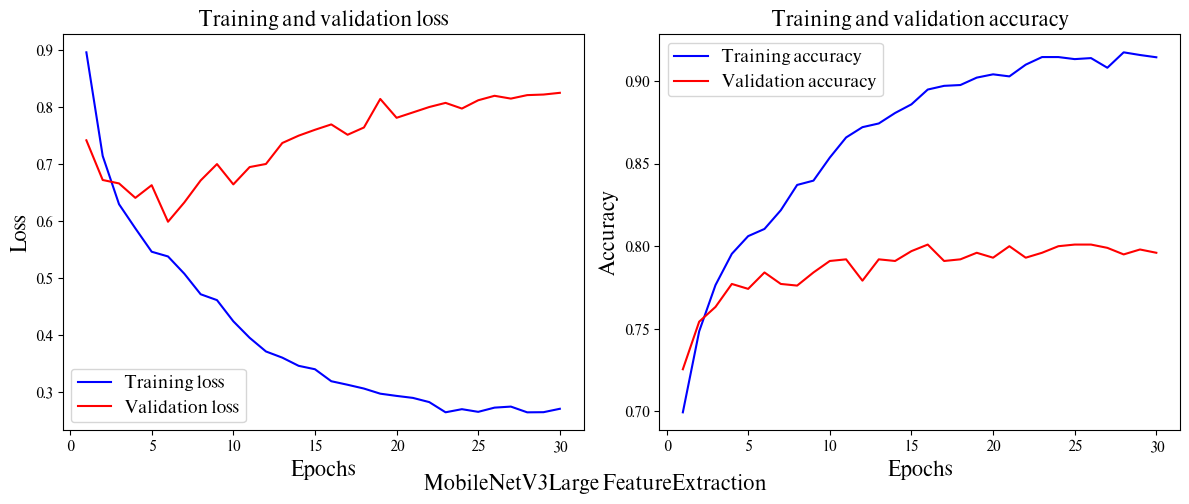

In [37]:
plot_history(history, save_path=ASSETS_FOR_MODEL_PATH, fontsize=14, title=f"{MODEL_NAME} {TYPE}")

### **Confusion Matrix**

In [38]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title=None, cmap=plt.cm.Blues,
                          save_path=None, fontsize=12):

    """
        สำหรับ Plot counfusion matrix
        Args:
            cm (array): ค่า confusion matrix ที่ต้องการ plot
            classes (list): รายชื่อคลาส (label names) สำหรับแกน X และ Y
            normalize (bool, default=False): ถ้า True จะทำ normalization ให้ค่าทุกแถวรวมเป็น 1
            title (str, optional): ชื่อกราฟที่จะแสดงด้านบน
            cmap (matplotlib colormap, default=plt.cm.Blues): โทนสีของ heatmap
            save_path (str, optional): โฟลเดอร์ที่จะบันทึกภาพ (ถ้าไม่กำหนดจะไม่บันทึก)
            fontsize (int, default=12): ขนาดตัวอักษรในกราฟ
    """
    correct_predictions = np.trace(cm)
    total_samples = np.sum(cm)
    accuracy = correct_predictions / total_samples
    misclassification_rate = 1 - accuracy

    if title:
        if normalize:
            pic_title = f"{title}\nConfusion Matrix (normalized)"
        else:
            pic_title = f"{title}\nConfusion Matrix"
    else:
        if normalize:
            pic_title = "Confusion Matrix (normalized)"
        else:
            pic_title = "Confusion Matrix"

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(pic_title, fontsize=fontsize, ha="center")
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=fontsize)
    plt.yticks(tick_marks, classes, fontsize=fontsize)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment="center",
                 fontsize=fontsize,
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=fontsize)
    metrics_text = (
        f"\nAccuracy: {accuracy:.4f}  |  Misclass: {misclassification_rate:.4f}"
    )
    plt.xlabel(f"Predicted label{metrics_text}", fontsize=fontsize)
    plt.tight_layout()

    if save_path:
        if normalize:
            plt.savefig(f"{save_path}/confusion_matrix_normalized.png", format="png", dpi=300, bbox_inches="tight")
            plt.savefig(f"{save_path}/confusion_matrix_normalized.svg", format="svg", bbox_inches="tight")
        else:
            plt.savefig(f"{save_path}/confusion_matrix.png", format="png", dpi=300, bbox_inches="tight")
            plt.savefig(f"{save_path}/confusion_matrix.svg", format="svg", bbox_inches="tight")

    plt.show()

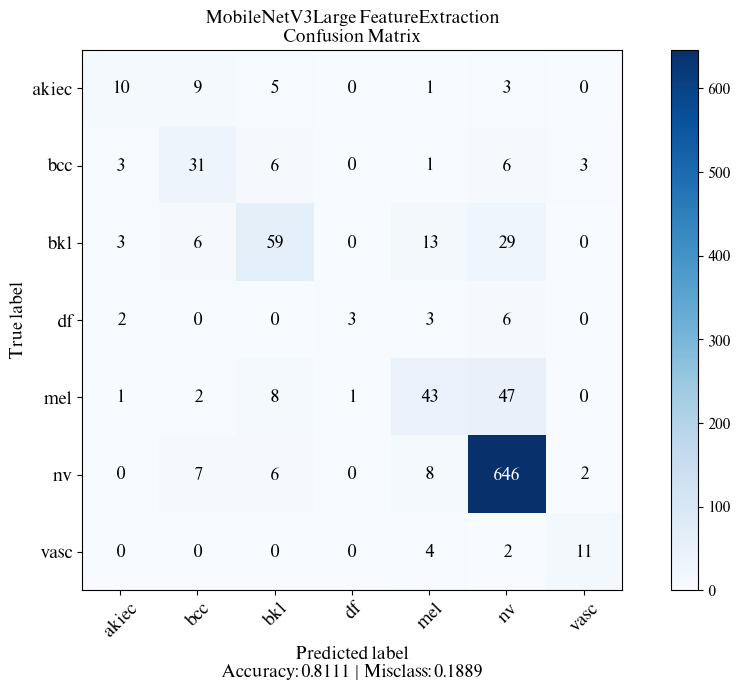

In [39]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))
plot_confusion_matrix(cm, class_names, title=f"{MODEL_NAME} {TYPE}", normalize=False, save_path=ASSETS_FOR_MODEL_PATH)

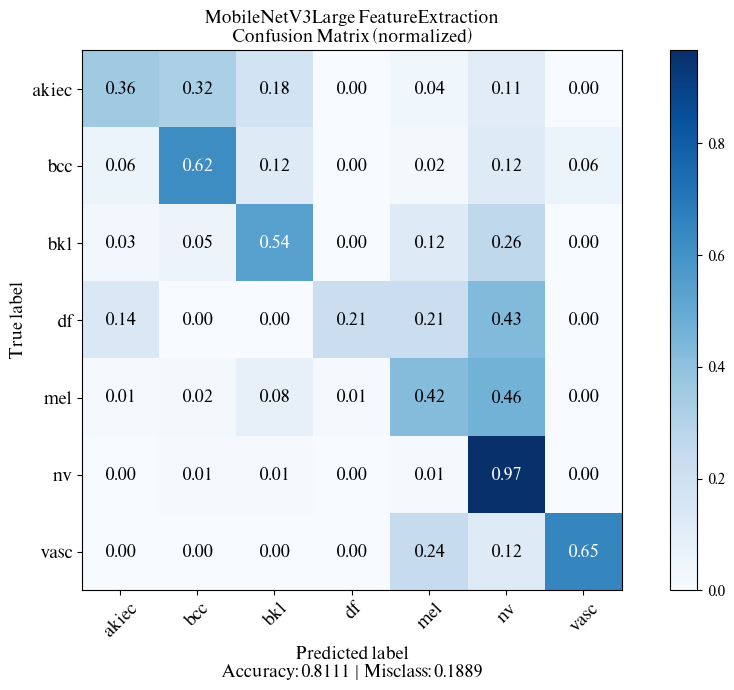

In [40]:
plot_confusion_matrix(cm, class_names, title=f"{MODEL_NAME} {TYPE}", normalize=True, save_path=ASSETS_FOR_MODEL_PATH)

### **Plot AUC-ROC Curve**

In [41]:
def plot_multi_class_roc(y_true_onehot, y_pred_prob, class_names, title=None, save_path=None, fontsize=14):
    """
        y_true_onehot (ndarray): ค่า ground truth ในรูปแบบ one-hot encoded (ขนาด n_samples × n_classes)
        y_pred_prob (ndarray): ค่าความน่าจะเป็นที่โมเดลทำนาย (ขนาดเดียวกันกับ y_true_onehot)
        class_names (list): รายชื่อคลาสแต่ละคลาสที่ใช้แสดงในกราฟ
        title (str, optional): ชื่อกราฟ (ถ้าไม่ระบุจะใช้ชื่อเริ่มต้น “Receiver Operating Characteristic (ROC) - Multiclass”)
        save_path (str, optional): โฟลเดอร์สำหรับบันทึกภาพ (.png และ .svg)
        fontsize (int, default=14): ขนาดตัวอักษรในกราฟ
    """
    n_classes = y_pred_prob.shape[1]
    plt.figure(figsize=(12, 7))

    if title:
        pic_title = f"{title}\nReceiver Operating Characteristic (ROC) - Multiclass"
    else:
        pic_title = "Receiver Operating Characteristic (ROC) - Multiclass"

    for i in range(n_classes):
        fpr, tpr, _ = sklearn.metrics.roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.4f})")

    fpr_micro, tpr_micro, _ = sklearn.metrics.roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
    roc_auc_micro = sklearn.metrics.auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, color="deeppink", linestyle="--", lw=2,
             label=f"Micro-average (AUC = {roc_auc_micro:.4f})")

    roc_auc_macro = sklearn.metrics.roc_auc_score(y_true_onehot, y_pred_prob, average='macro')
    plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--",
             label=f"Macro-average (AUC = {roc_auc_macro:.4f})")

    plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle=":")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=fontsize)
    plt.ylabel("True Positive Rate", fontsize=fontsize)
    plt.title(pic_title, fontsize=fontsize)
    plt.legend(loc="lower right", fontsize=fontsize)
    plt.grid(alpha=0.3)

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    if save_path:
        plt.savefig(f"{save_path}/roc_auc_curve.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}/roc_auc_curve.svg", format="svg", bbox_inches="tight")

    plt.show()

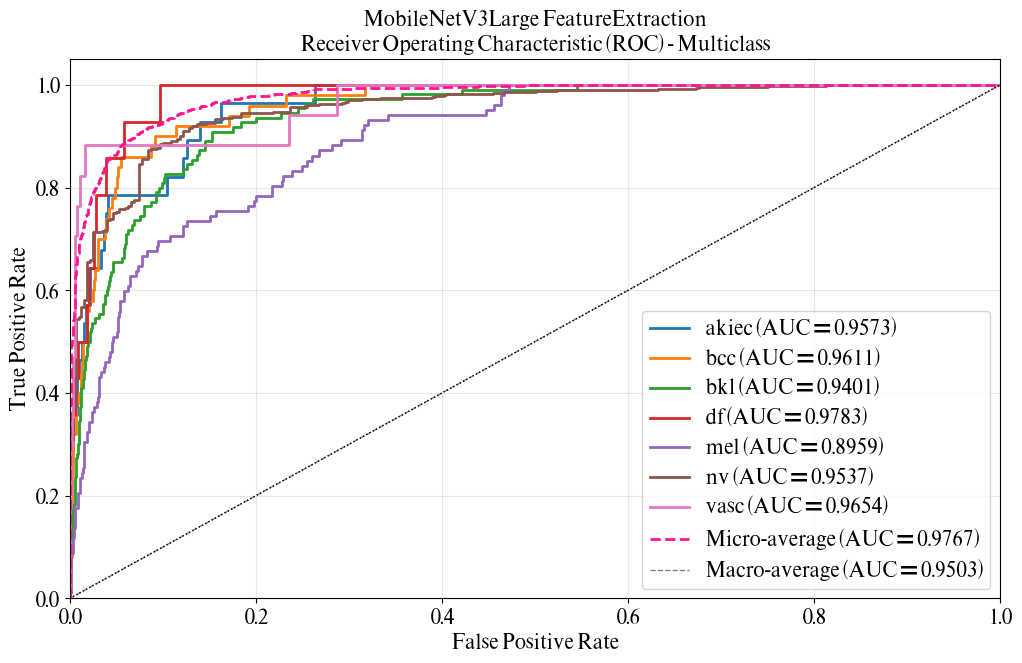

In [42]:
plot_multi_class_roc(y_true_onehot, y_pred_prob, class_names, f"{MODEL_NAME} {TYPE}", ASSETS_FOR_MODEL_PATH)

## **Section 6: Explainable AI (XAI)**

In [43]:
def prepare_unique_image_from_dataset(dataset, y_pred, idx_to_class, num_images=7, random_state=42):
    images_all, metadata_all, labels_all = [], [], []

    for (img, meta), label in dataset.unbatch():
        images_all.append(img.numpy())
        metadata_all.append(meta.numpy())
        labels_all.append(np.argmax(label.numpy()))

    images_all = np.array(images_all)
    metadata_all = np.array(metadata_all)
    labels_all = np.array(labels_all)

    unique_classes = np.unique(labels_all)
    num_images = min(num_images, len(unique_classes))

    rng = np.random.default_rng(random_state)
    sampled_indices = [rng.choice(np.where(labels_all==cls)[0], size=1, replace=False)[0] for cls in unique_classes]

    sampled_indices = sampled_indices[:num_images]

    raw_imgs, meta_array, pred_titles, true_titles = [], [], [], []
    for idx in sampled_indices:
        raw_imgs.append(images_all[idx])
        meta_array.append(metadata_all[idx])
        true_titles.append(idx_to_class[labels_all[idx]])
        pred_titles.append(idx_to_class[y_pred[idx]])

    return raw_imgs, meta_array, pred_titles, true_titles, sampled_indices

In [44]:
raw_imgs, meta_array, pred_titles, true_titles, sampled_indices = prepare_unique_image_from_dataset(
    dataset=ds_test,
    y_pred=y_pred,
    idx_to_class=idx_to_class,
    num_images=NUM_CLASSES,
    random_state=SEED
)

In [45]:
def get_gradcam_heatmap_multi_input(model, input_array, layer_name, class_idx=None):
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8
    return heatmap.numpy()

In [46]:
def overlay_heatmap_on_image(img, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, colormap)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    overlay_img = cv2.addWeighted(img.astype(np.uint8), 1-alpha, heatmap_color, alpha, 0)
    return overlay_img

In [47]:
def visualize_predict_images(model, raw_imgs, meta_array, pred_titles,
                     true_titles, title, last_conv_layer_name=None, overlay=False,
                     alpha=0.5, fontsize=16, save_path=None):
    """
    แสดงภาพตัวอย่างพร้อมผลการทำนายของโมเดล และสามารถทำ Grad-CAM overlay ได้
    พร้อมแสดงค่าความเชื่อมั่นของแต่ละภาพ

    Args:
        model: โมเดล Keras สำหรับทำ Grad-CAM หรือคำนวณ confidence
        raw_imgs (list[np.ndarray]): ลิสต์ของภาพ
        meta_array (list[np.ndarray]): ลิสต์ของ metadata (ใช้สำหรับ multi-input model)
        pred_titles (list[str]): รายชื่อคลาสที่โมเดลทำนายได้
        true_titles (list[str]): รายชื่อคลาสจริง
        title (str, optional): ชื่อหัวข้อ
        last_conv_layer_name (str, optional): ชื่อ layer สำหรับ Grad-CAM
        overlay (bool, default=False): ทำ Grad-CAM overlay หรือไม่
        alpha (float, default=0.5): ความเข้มของ heatmap overlay
        fontsize (int, default=16): ขนาดตัวอักษร
        save_path (str, optional): โฟลเดอร์สำหรับบันทึกภาพ
    """
    num_images = len(raw_imgs)
    num_rows = 1
    fig, axes = plt.subplots(num_rows, num_images, figsize=(21, 4))
    axes = np.atleast_1d(axes).flatten()

    for i, ax in enumerate(axes):
        img = raw_imgs[i]
        is_correct = (pred_titles[i] == true_titles[i])
        title_color = 'green' if is_correct else 'red'

        confidence_text = ""
        if model is not None:
            inputs = [np.expand_dims(img, axis=0)]
            if meta_array is not None:
                meta = meta_array[i]
                inputs.append(np.expand_dims(meta, axis=0))
            preds = model.predict(inputs, verbose=0)
            prob = preds[0]
            pred_idx = np.argmax(prob)
            confidence = prob[pred_idx]
            confidence_text = f"Confidence : {confidence:.2f}"

        sub_title = f"Predict: {pred_titles[i]} | True: {true_titles[i]}\n{confidence_text}"

        if overlay and model is not None and last_conv_layer_name is not None:
            inputs = [np.expand_dims(img, axis=0)]
            if meta_array is not None:
                inputs.append(np.expand_dims(meta_array[i], axis=0))
            heatmap = get_gradcam_heatmap_multi_input(model, inputs, last_conv_layer_name)
            img_disp = overlay_heatmap_on_image(img, heatmap, alpha=alpha)
            ax.imshow(img_disp)
        else:
            ax.imshow(img.astype(np.uint8))

        ax.set_title(sub_title, color=title_color, fontsize=fontsize)
        ax.axis('off')

    if overlay:
        display_title = title + " Gradient Weighted Class Activation Mapping"
    else:
        display_title = title + " Prediction"

    fig.suptitle(display_title, fontsize=fontsize + 2, fontweight="bold", y=1.0)
    plt.tight_layout()
    fig.subplots_adjust(top=0.75)

    if save_path:
        if overlay:
            plt.savefig(f"{save_path}/image_predict_gradcam.png", format="png", dpi=300, bbox_inches="tight")
            plt.savefig(f"{save_path}/image_predict_gradcam.svg", format="svg", bbox_inches="tight")
        else:
            plt.savefig(f"{save_path}/image_predict.png", format="png", dpi=300, bbox_inches="tight")
            plt.savefig(f"{save_path}/image_predict.svg", format="svg", bbox_inches="tight")

    plt.show()

### **Visualize image prediction**

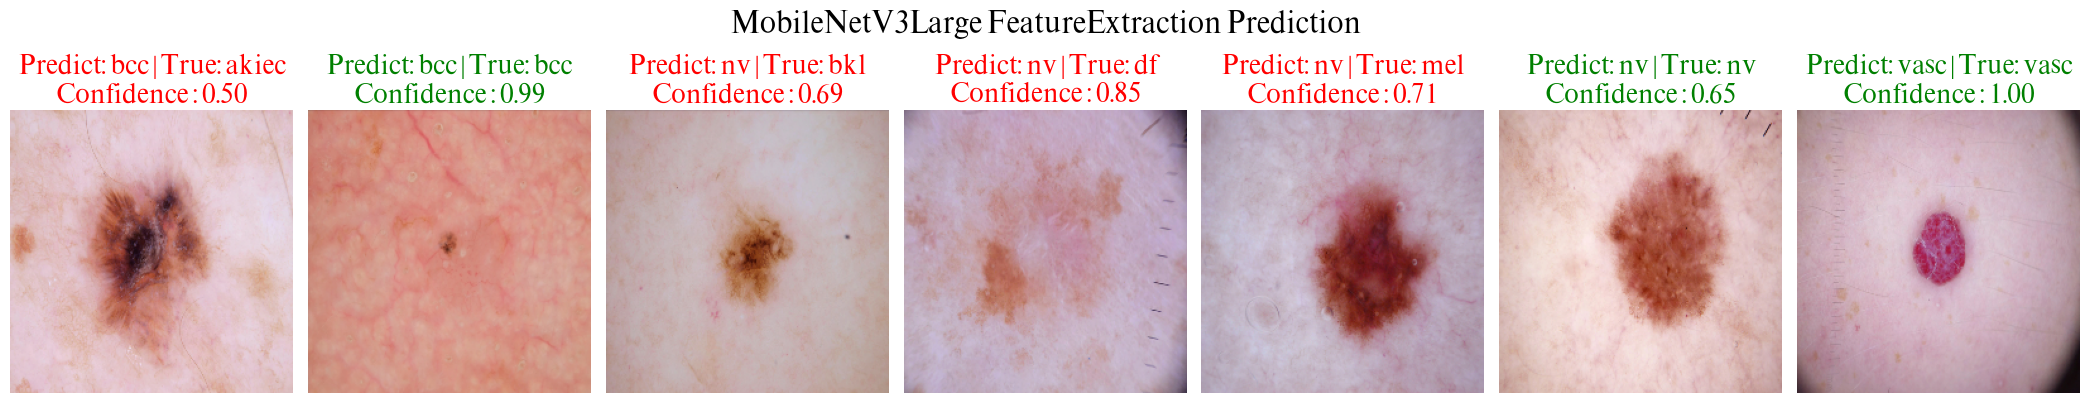

In [48]:
visualize_predict_images(
    model=model,
    raw_imgs=raw_imgs,
    meta_array=meta_array,
    pred_titles=pred_titles,
    true_titles=true_titles,
    title=f"{MODEL_NAME} {TYPE}",
    last_conv_layer_name=None,
    overlay=False,
    alpha=0.0,
    fontsize=18,
    save_path=ASSETS_FOR_MODEL_PATH
)

In [49]:
LAST_CONV_LAYER_NAME = "conv_1" # <= เปลี่ยนทุกครั้ง
preprocessed_imgs = [preprocess_input(img.astype(np.float32)) for img in raw_imgs]

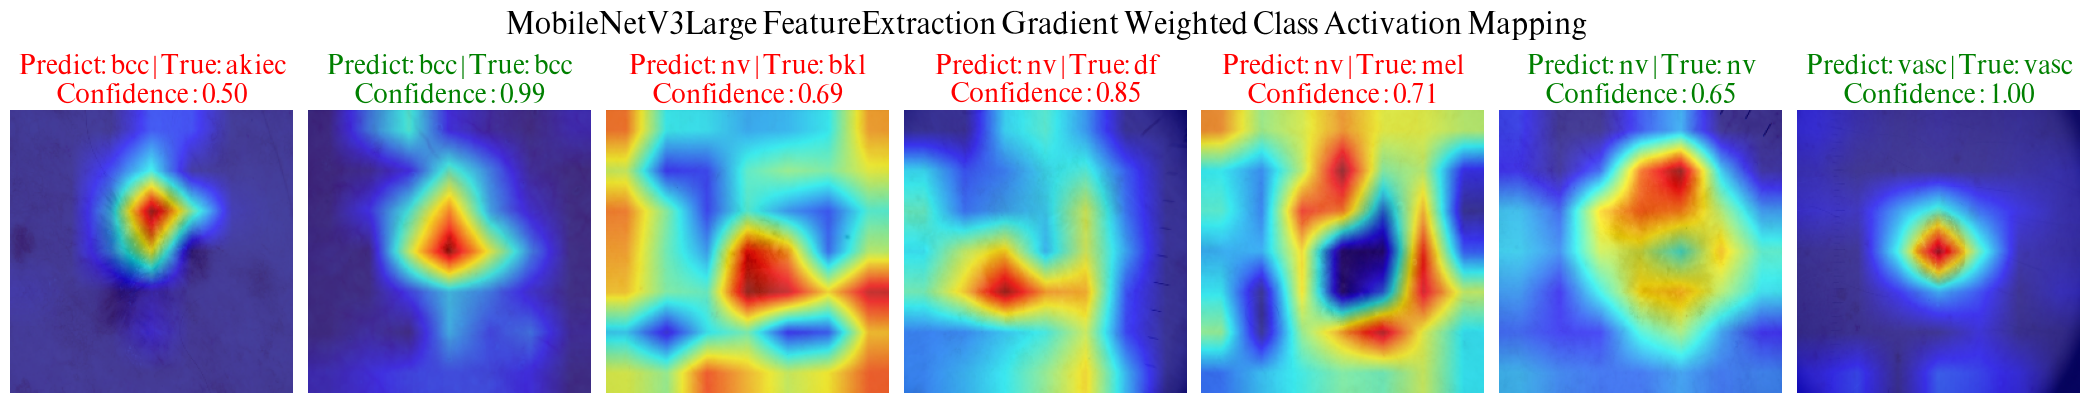

In [50]:
visualize_predict_images(
    model=model,
    raw_imgs=preprocessed_imgs,
    meta_array=meta_array,
    pred_titles=pred_titles,
    true_titles=true_titles,
    title=f"{MODEL_NAME} {TYPE}",
    last_conv_layer_name=LAST_CONV_LAYER_NAME,
    overlay=True,
    alpha=0.7,
    fontsize=18,
    save_path=ASSETS_FOR_MODEL_PATH
)